In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seml
import pandas as pd
import json
from collections import defaultdict
from functools import reduce
import seaborn as sns
from itertools import product
from scipy.stats import binned_statistic
from matplotlib.lines import Line2D

In [2]:
collection_name = 'week12_spectral_norm_cora_ml'
collection = seml.database.get_collection(collection_name)
experiments = [{'config' : r['config'], 'result' : r['result'], 'id' : r['_id']} for r in collection.find() if r['status'] in ('COMPLETED',)]
for ex in experiments:
    with open(ex['result']) as f:
        ex['result'] = json.load(f)

print(f'Number of finished experiments : {len(experiments)}')

Number of finished experiments : 152


In [3]:
for k, v in ex['result'].items():
    print(k, np.mean(v))

val_loss-val-0 0.5760804009437561
val_accuracy-val-0 0.8194285798072815
accuracy_val 0.8194285798072815
accuracy_id_val 0.8194285798072815
accuracy_ood_val nan
accuracy_val_no-edges 0.7599999952316284
accuracy_id_val_no-edges 0.7599999952316284
accuracy_ood_val_no-edges nan
ece_val 0.09065575849157677
ece_val_no-edges 0.07997503753218647
empirical_lipschitz_val_slope_mean_perturbation_noise 0.5549600200967234
empirical_lipschitz_val_slope_median_perturbation_noise 0.4992659102708011
empirical_lipschitz_val_slope_max_perturbation_noise 2.2152522019059666
empirical_lipschitz_val_slope_min_perturbation_noise 0.028754627196339224
empirical_lipschitz_val_slope_mean_perturbation_derangement 0.9818724141911435
empirical_lipschitz_val_slope_median_perturbation_derangement 0.8709731464479985
empirical_lipschitz_val_slope_max_perturbation_derangement 158.15480621141182
empirical_lipschitz_val_slope_min_perturbation_derangement 0.0
accuracy_ber_ber-no-edges 0.4768223035335541
accuracy_id_ber_ber-

In [4]:
SETTING = 'Setting'
RESIDUAL = 'Residual'
SPECTRAL_NORM = 'Spectral Normalzation'
NORMALIZE_OUTPUT = 'Spectral Output Normalization'
ACCURACY = 'Accuracy'
ECE = 'Expected Calibration Error'
WEIGHT_SCALE = 'Weight Scale'
LIPSCHITZ = 'Median Empirical Lipschitz Constant'
LIPSCHITZ_MAX = 'Empirical Upper Lipschitz Constant'
LIPSCHITZ_MIN = 'Empirical Lower Lipschitz Constant'
OOD = 'Out of Distribution Setting'
PROXY = 'Proxy'
LOC = 'Leave out Classes'
BERNOULLI = 'Bernoulli'
NORMAL = 'Normal'
GPC = 'Feature Density'
MAX_SCORE = 'Max Score'
AUROC = 'AUC-ROC'
TRANSDUCTIVE = 'Transductive'
HYBRID = 'Hybrid'
NO_EDGES = 'Remove Edges'

In [5]:
data = []
data_auroc = []
for ex_idx, ex in enumerate(experiments):
    for idx in range(ex['config']['data']['num_dataset_splits'] * ex['config']['model']['num_initializations']):
        
        
        base = {
            SETTING : ex['config']['data']['setting'].capitalize(),
            RESIDUAL : ex['config']['model']['residual'],
            SPECTRAL_NORM : ex['config']['model']['use_spectral_norm'],
            WEIGHT_SCALE : (ex['config']['model']['weight_scale']),
            LIPSCHITZ : ex['result']['empirical_lipschitz_val_slope_median_perturbation_noise'][idx],
            LIPSCHITZ_MAX : ex['result']['empirical_lipschitz_val_slope_max_perturbation_noise'][idx],
            LIPSCHITZ_MIN : ex['result']['empirical_lipschitz_val_slope_min_perturbation_noise'][idx],
            '_EXPERIMENT_IDX' : ex_idx,
        }
        if ex['config']['model']['use_spectral_norm'] == False:
            # Duplicate the values for no spectral norm (once with and once without output normalization)
            base[NORMALIZE_OUTPUT] = False
            base[WEIGHT_SCALE] = -1
        else:
            base[NORMALIZE_OUTPUT] = ex['config']['model']['use_spectral_norm_on_last_layer']

        data.append(base | {
            ACCURACY : ex['result']['accuracy_val'][idx],
            ECE : ex['result']['ece_val'][idx],
        })
        for k in ex['result'].keys():
            v = ex['result'][k][idx]
            if 'auroc' not in k:
                continue
            if 'no-edges' in k: 
                k = k.replace('-no-edges', '')
                no_edges = True
            else:
                no_edges = False
            if k.endswith('loc'):
                ood = LOC
            elif k.endswith('ber'):
                ood = BERNOULLI
            elif k.endswith('normal'):
                ood = NORMAL
            else:
                continue
            if 'gpc-diag-weighted:no' in k:
                data_auroc.append(base | {
                    PROXY : GPC,
                    AUROC : v,
                    OOD : ood,
                    NO_EDGES : no_edges,
                })
            elif 'max-score' in k:
                data_auroc.append(base | {
                    PROXY : MAX_SCORE,
                    AUROC : v,
                    OOD : ood,
                    NO_EDGES : no_edges,
                })
            else:
                continue
        
df = pd.DataFrame(data)
df_auroc = pd.DataFrame(data_auroc)
df_merged = pd.merge(df_auroc, df)

In [6]:
np.unique(df_auroc[NO_EDGES])

array([False,  True])

In [7]:
def plot_facet_lines_with_uncertainty_and_no_spectral_norm_as_point(df, x=None, y=None, row=None, col=None, hue=None, style=None, 
                                      ci=95, 
                                      facet_kws = {'margin_titles' : True, 'height' : 4, }, log_x = True):
    
    g = sns.FacetGrid(df, row = row, col = col, hue = hue, **facet_kws)
    
    styles = ['solid', 'dotted', 'dashed']
    markers = ['o', 'x', '+']
    label_to_color = {}
    style_to_linestyle = {}
    style_to_marker = {}
    style_name = style
    
    def plot_lines(x, y, style, sn, color=None, label=None, ci=ci):
        label_to_color[label] = color
        
        for style_idx, st in enumerate(sorted(np.unique(style).tolist())):
            style_to_linestyle[st] = styles[style_idx]
            style_to_marker[st] = markers[style_idx]
            # Bin the ones with spectral norm according to lipschitz constant
            
            x_style, y_style = x[(style == st) & (sn == True)], y[(style == st) & (sn == True)]
            if log_x:
                x_style = np.log(x_style)
            
            mean, bin_edges, bin_idx = binned_statistic(x_style, y_style, statistic='mean', bins=10)
            std, _, _ = binned_statistic(x_style, y_style, bins=bin_edges, statistic='std')
            bin_centers = (0.5 * (bin_edges[:-1] + bin_edges[1:]))
            if log_x:
                bin_centers = np.exp(bin_centers)
            
            plot_mask = np.isfinite(mean) & np.isfinite(std)
            
            plt.plot(bin_centers[plot_mask], mean[plot_mask], color=color, label=f'{label}, {st}', linestyle=styles[style_idx])
            plt.fill_between(bin_centers[plot_mask],( mean - std)[plot_mask], (mean + std)[plot_mask], alpha = 0.2, color=color)
            
            # Put the ones without spectral norm into one bin put as a point
            x_style, y_style = x[(style == st) & (sn == False)], y[(style == st) & (sn == False)]
            x_std, y_std = x_style.std(), y_style.std()
            _x, _y = np.array([x_style.mean()]), np.array([y_style.mean()])
            if (np.isfinite(_x) & np.isfinite(_y)).all():
                plt.errorbar(_x, _y, yerr=y_style.std(), xerr = x_style.std(), ecolor='gray', capsize=2, fmt=markers[style_idx], color=color)
        
    g.map(plot_lines, x, y, style, SPECTRAL_NORM, ci=ci)
    
    # Create a legend (extremely hacky)
    
    lines, line_labels = [], []
    for label, color in label_to_color.items():
        lines.append(Line2D([0], [0], color=color))
        line_labels.append(label)
    l1 = plt.legend(lines, line_labels, title=hue, loc='center left', bbox_to_anchor=(1.1, 1.25))
    
    lines, line_labels = [], []
    for style, ls in style_to_linestyle.items():
        lines.append(Line2D([0], [0], color='black', ls=ls))
        line_labels.append(style)
    l2 = plt.legend(lines, line_labels, title=f'{style_name}', loc='center left', bbox_to_anchor=(1.1, 1.0))
    
    
    lines, line_labels = [], []
    for style, marker in style_to_marker.items():
        lines.append(plt.errorbar([], [], xerr=[], yerr=[], color='black', ecolor='gray', capsize=10, fmt=marker))
        line_labels.append(style)
    l3 = plt.legend(lines, line_labels, title=f'{style_name},\nNo Spectral Norm', loc='center left', bbox_to_anchor=(1.1, 0.7))
    
    g.axes.flatten()[-1].add_artist(l1)
    g.axes.flatten()[-1].add_artist(l2)
    
    
    if log_x:
        g.set(xscale='log')
    return g


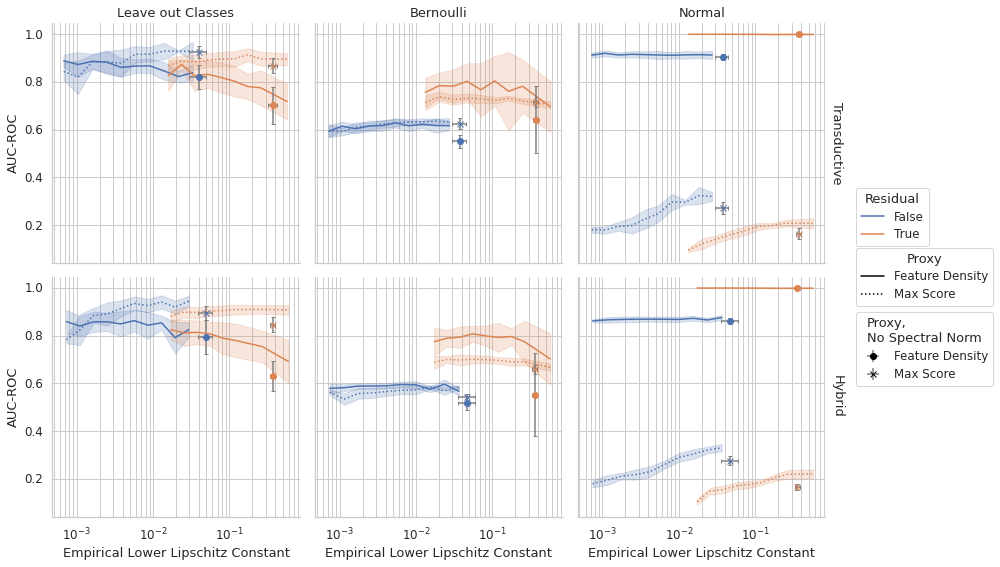

In [8]:

sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")

g = plot_facet_lines_with_uncertainty_and_no_spectral_norm_as_point(
    df_auroc[(df_auroc[NO_EDGES] == False) & (df_auroc[NORMALIZE_OUTPUT] == False)],
    x = LIPSCHITZ_MIN, y = AUROC, col = OOD, row = SETTING, hue = RESIDUAL, style = PROXY)
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

In [ ]:

sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")

g = plot_facet_lines_with_uncertainty_and_no_spectral_norm_as_point(
    df_auroc[(df_auroc[NO_EDGES] == True) & (df_auroc[NORMALIZE_OUTPUT] == False)],
    x = LIPSCHITZ_MIN, y = AUROC, col = OOD, row = SETTING, hue = RESIDUAL, style = PROXY)
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

In [7]:
def plot_facet_lines_with_uncertainty_and_no_spectral_norm_as_point_no_style(df, x=None, y=None, row=None, col=None, hue=None, 
                                      ci=95, 
                                      facet_kws = {'margin_titles' : True, 'height' : 4, }, log_x = True):
    
    g = sns.FacetGrid(df, row = row, col = col, hue = hue, **facet_kws)
    
    styles = ['solid', 'dotted', 'dashed']
    markers = ['o', 'x', '+']
    label_to_color = {}
    style_to_linestyle = {}
    style_to_marker = {}
    
    def plot_lines(x, y, sn, color=None, label=None, ci=ci):
        label_to_color[label] = color
        
            
        # Bin the ones with spectral norm according to lipschitz constant

        x_style, y_style = x[(sn == True)], y[(sn == True)]
        if log_x:
            x_style = np.log(x_style)

        mean, bin_edges, bin_idx = binned_statistic(x_style, y_style, statistic='mean', bins=10)
        std, _, _ = binned_statistic(x_style, y_style, bins=bin_edges, statistic='std')
        bin_centers = (0.5 * (bin_edges[:-1] + bin_edges[1:]))
        if log_x:
            bin_centers = np.exp(bin_centers)

        plot_mask = np.isfinite(mean) & np.isfinite(std)

        plt.plot(bin_centers[plot_mask], mean[plot_mask], color=color, label=f'{label}', )
        plt.fill_between(bin_centers[plot_mask],( mean - std)[plot_mask], (mean + std)[plot_mask], alpha = 0.2, color=color)

        # Put the ones without spectral norm into one bin put as a point
        x_style, y_style = x[(sn == False)], y[(sn == False)]
        x_std, y_std = x_style.std(), y_style.std()
        _x, _y = np.array([x_style.mean()]), np.array([y_style.mean()])
        if (np.isfinite(_x) & np.isfinite(_y)).all():
            plt.errorbar(_x, _y, yerr=y_style.std(), xerr = x_style.std(), ecolor='gray', capsize=2, color=color, marker='o')
        
    g.map(plot_lines, x, y, SPECTRAL_NORM, ci=ci)

    
    # Create a legend (extremely hacky)
    
    lines, line_labels = [], []
    for label, color in label_to_color.items():
        lines.append(Line2D([0], [0], color=color))
        line_labels.append(label)
    l1 = plt.legend(lines, line_labels, title=hue, loc='center left', bbox_to_anchor=(1.1, 2.0))    
    
    lines, line_labels = [], []
    lines.append(plt.errorbar([], [], xerr=[], yerr=[], color='black', ecolor='gray', capsize=10, fmt='o'))
    line_labels.append('')
    l3 = plt.legend(lines, line_labels, title=f'No Spectral Norm', loc='center left', bbox_to_anchor=(1.1, 1.75))
    
    
    g.axes.flatten()[-1].add_artist(l1)
    
    if log_x:
        g.set(xscale='log')
    return g


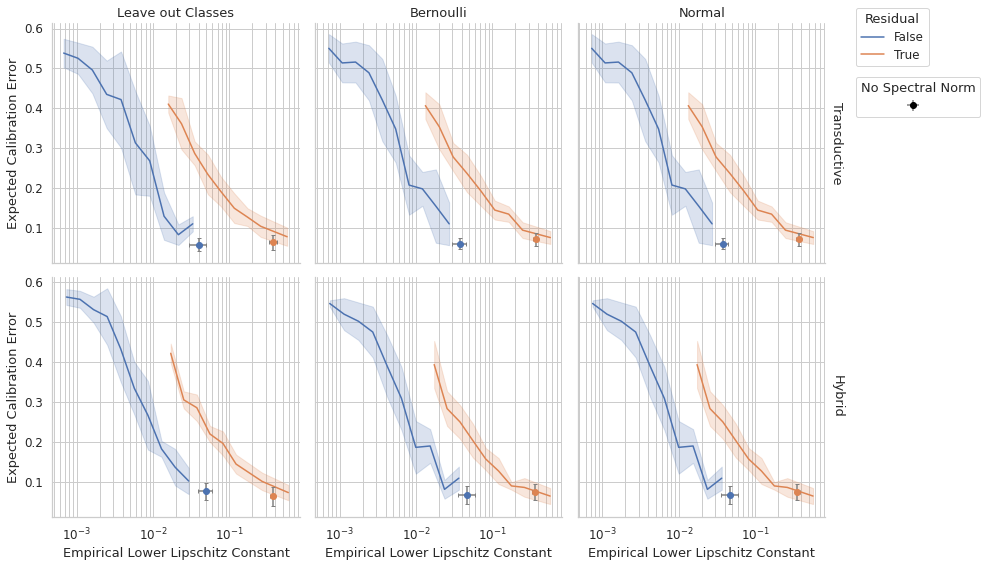

In [123]:

sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")

g = plot_facet_lines_with_uncertainty_and_no_spectral_norm_as_point_no_style(
    df_merged[(df_merged[NO_EDGES] == False) & (df_merged[NORMALIZE_OUTPUT] == False)],
    x = LIPSCHITZ_MIN, y = ECE, col = OOD, row = SETTING, hue = RESIDUAL)
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

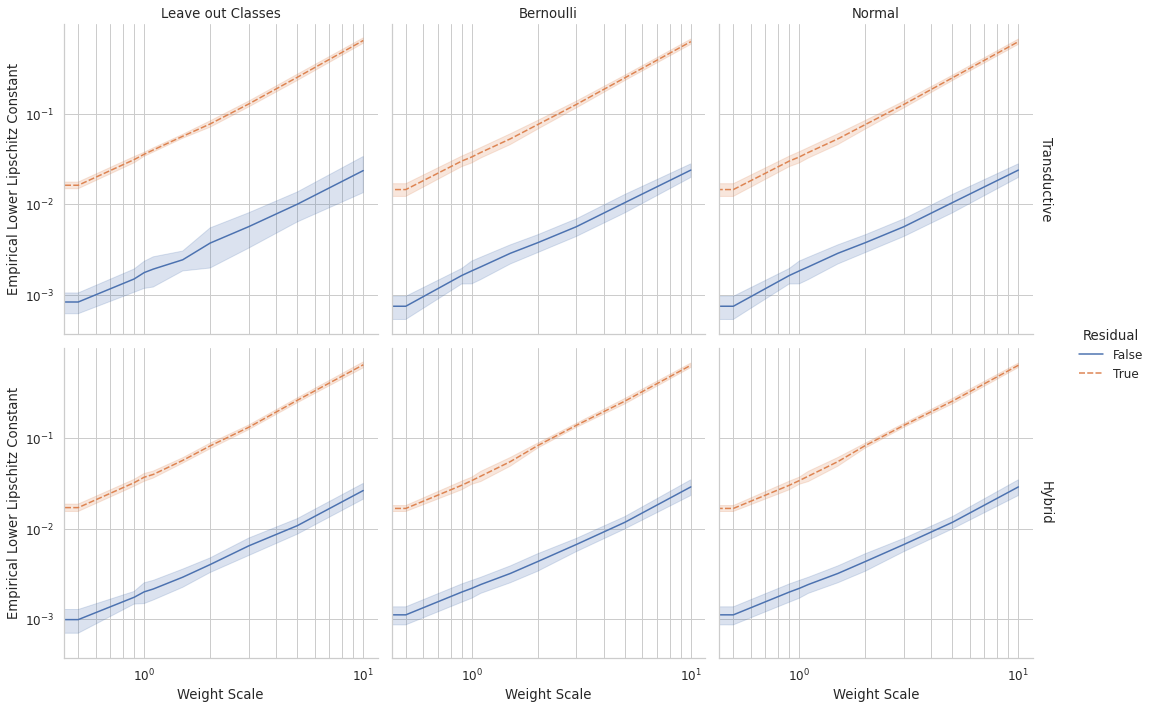

In [16]:

sns.set(context='notebook', font_scale=1.1)
sns.set_style("whitegrid")
g = sns.relplot(data = df_merged[(df_merged[NO_EDGES] == False) & (df_merged[NORMALIZE_OUTPUT] == False)] , 
                x = WEIGHT_SCALE, y = LIPSCHITZ_MIN, hue = RESIDUAL, col = OOD, 
                row = SETTING, kind='line', facet_kws = {'margin_titles' : True}, style=RESIDUAL, ci='sd')
g.set(xscale='log')
g.set(yscale='log')
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')